__In this notebook we are trying to split our dataset into several stations__   
Indeed, we want to predict the number of docks available for every station possible, but my machine can't train such a model. In addition, our model's performances wouldn't be so great with more than 1400 encoded stations.

My approach is to divide the stations into clusters and to train one model for each cluster.   
Let's do this :)

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

pd.options.mode.chained_assignment = None

In [207]:
df = pd.read_csv('/Users/sebastienvallin/code/Sebastien01/velib_prediction/raw_data/historique_velib_v2.csv',
                index_col=0)
print(f'Shape : {df.shape}')
df.head()

/Users/sebastienvallin/.pyenv/versions/3.8.12/envs/sebenv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Shape : (2719493, 16)


,station_id,docks_available,is_installed,is_returning,is_renting,mechanical_available,ebike_available,time,name,lat,lon,capacity,temp2m,probarain,weather,wind10m
0,213688169,31,True,True,True,3,1,2022-03-19 17:26:50,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,15.0,0.0,0.0,26.0
1,516709288,19,True,True,True,0,1,2022-03-19 17:26:50,Charonne - Robert et Sonia Delauney,48.855908,2.392571,20,15.0,0.0,0.0,26.0
2,36255,14,True,True,True,0,7,2022-03-19 17:26:50,Toudouze - Clauzel,48.879296,2.337360,21,15.0,0.0,0.0,26.0
3,37815204,22,True,True,True,3,4,2022-03-19 17:26:50,Mairie du 12ème,48.840855,2.387555,30,15.0,0.0,0.0,26.0
4,100769544,0,True,True,True,22,23,2022-03-19 17:26:50,Harpe - Saint-Germain,48.851519,2.343670,45,15.0,0.0,0.0,26.0


In [208]:
for col in ['is_installed', 'is_returning','is_renting']:
    df[col] = df[col].map({True:1, False:0})

closed_stations = [st for st in df.station_id.unique() 
                   if (df[(df.station_id==st)].is_installed.sum() / df[(df.station_id==st)].shape[0]) < 0.8]

df = df[~df.station_id.isin(closed_stations)]
df = df[~(df.is_installed ==0)]
df = df[~(df.is_returning ==0)]
df = df[~(df.is_renting ==0)]

In [209]:
df.isna().sum()/df.shape[0]

station_id              0.0
docks_available         0.0
is_installed            0.0
is_returning            0.0
is_renting              0.0
mechanical_available    0.0
ebike_available         0.0
time                    0.0
name                    0.0
lat                     0.0
lon                     0.0
capacity                0.0
temp2m                  0.0
probarain               0.0
weather                 0.0
wind10m                 0.0
dtype: float64

In [210]:
df.shape[0] - df.drop_duplicates().shape[0]

0

# Clustering

## Feature engineering

In [81]:
station_df = pd.read_csv('/Users/sebastienvallin/code/Sebastien01/velib_prediction/velib_prediction/data/stations_info.csv',
                        index_col=0)

_ = df.copy()

_['time'] = pd.to_datetime(df['time'])
_['hour'] = _['time'].dt.hour
_['day'] = _['time'].dt.dayofweek

_.set_index('time', inplace=True)

stacked_df = _.groupby([pd.Grouper('station_id'),
                        pd.Grouper(level='time',freq='H')]).agg({'docks_available':'mean',
                                                                     'is_returning':min,
                                                                     'is_renting':min,
                                                                     'mechanical_available':'mean',
                                                                     'ebike_available':'mean',
                                                                     'capacity':max})

stacked_df['hour'] = stacked_df.index.droplevel(0).hour
stacked_df.head()

docks_available  is_returning  is_renting  \
station_id time                                                             
6245       2022-03-19 17:00:00         1.333333          True        True   
           2022-03-19 18:00:00         1.666667          True        True   
           2022-03-19 19:00:00         2.750000          True        True   
           2022-03-19 20:00:00         4.500000          True        True   
           2022-03-19 21:00:00         8.750000          True        True   

                                mechanical_available  ebike_available  \
station_id time                                                         
6245       2022-03-19 17:00:00             14.666667            11.00   
           2022-03-19 18:00:00             15.833333             9.50   
           2022-03-19 19:00:00             15.000000             9.25   
           2022-03-19 20:00:00             14.500000             8.00   
           2022-03-19 21:00:00             14.500000             3.25   

                                capacity  hour  
station_id time                                 
6245       2022-03-19 17:00:00        27    17  
           2022-03-19 18:00:00        27    18  
           2022-03-19 19:00:00        27    19  
           2022-03-19 20:00:00        27    20  
           2022-03-19 21:00:00        27    21

In [82]:
daily_var = [stacked_df.query(f'station_id=={station}')['docks_available'].var() 
             for station in station_df.station_id]

daily_mean = [stacked_df.query(f'station_id=={station}')['docks_available'].mean() 
             for station in station_df.station_id]

morning_var = [stacked_df.query(f'station_id=={station} & hour.between(6,12,"left")')['docks_available'].var() 
               for station in station_df.station_id]

morning_mean = [stacked_df.query(f'station_id=={station} & hour.between(6,12,"left")')['docks_available'].mean() 
               for station in station_df.station_id]

eve_var = [stacked_df.query(f'station_id=={station} & hour.between(15,20,"left")')['docks_available'].var() 
               for station in station_df.station_id]

eve_mean = [stacked_df.query(f'station_id=={station} & hour.between(15,20,"left")')['docks_available'].mean() 
               for station in station_df.station_id]

featured_df = pd.DataFrame({'daily_var' : daily_var,
                            'daily_mean': daily_mean,
                            'morning_var': morning_var,
                            'morning_mean': morning_mean,
                            'eve_var': eve_var,
                            'eve_mean': eve_mean})

In [83]:
cluster_df = pd.concat((station_df,featured_df),axis=1)
cluster_df = cluster_df.dropna()

cluster_df = cluster_df.set_index('station_id').drop(columns='name')

cluster_df.head(2)

,lat,lon,capacity,cluster,daily_var,daily_mean,morning_var,morning_mean,eve_var,eve_mean
station_id,,,,,,,,,,
213688169,48.865983,2.275725,35,0,37.072147,27.394755,33.931845,27.339947,53.114592,27.228741
516709288,48.855908,2.392571,20,4,11.233045,15.409248,14.156277,14.713624,5.642849,16.983844


Let's try to identify an ideal number of clusters

## Selecting the best model to split the stations

In [ ]:
from sklearn.decomposition import PCA

In [84]:
pca3 = PCA(n_components=3).fit(cluster_df)
ar3 = pca3.transform(cluster_df)

In [85]:
fig = go.Figure(data=[go.Scatter3d(
    x=ar3[:,0],
    y=ar3[:,1],
    z=ar3[:,2],
    mode='markers',
    marker=dict(
        size=12, 
        color = ar3[:,1],
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.show()

<img src="plotly_graphs/PCA_plot.png">

We can't really distinguish a clear number of clusters with 3 dimensions...

In [86]:
pca9 = PCA(n_components=9).fit(cluster_df)

cluster_df = pd.DataFrame(pca9.transform(cluster_df),
                          columns=[f'PC_{i}' for i in range(9)],
                          index = cluster_df.index)

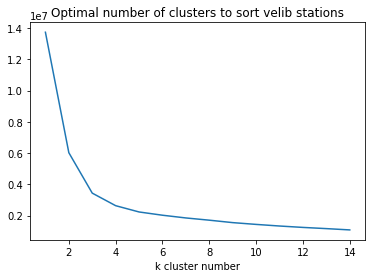

In [87]:
inertias = []
ks = range(1,15)
for k in ks:
    km = KMeans(n_clusters=k).fit(cluster_df)
    inertias.append(km.inertia_)
plt.plot(ks, inertias)
plt.xlabel('k cluster number')
plt.title('Optimal number of clusters to sort velib stations');

We could choose to make 6 clusters, which seems to be a good compromise to split well our stations, but I want to split my dataset as much as possible to have lighter models. I'll go with 10 clusters

## Analysing the clusters

In [138]:
from sklearn.cluster import KMeans

In [133]:
def make_cluster(model):
    st_df = station_df.copy()[['station_id','name','lat','lon','capacity']]
    clus_df = cluster_df.copy()[['PC_0', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8']]
    model = model.fit(clus_df)
    clus_df['cluster'] = model.predict(clus_df)
    return st_df.merge(clus_df.reset_index()[['station_id', 'cluster']], on='station_id').drop_duplicates()

In [187]:
m = KMeans(n_clusters=10)
km_df = make_cluster(m)
km_df.cluster.value_counts()

7    420
4    311
2    228
0    200
6     97
8     70
3     57
1     23
5     17
9      7
Name: cluster, dtype: int64

In [337]:
biggest_clusters = [cl for cl in km_df.cluster.unique() if (km_df.cluster==cl).sum()>150]

The split is not really equal, maybe we'll split the cluster n°7. Let's see how our stations are split.

In [159]:
def plot_capa(dataframe):
    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(hspace=0.5)
    n_cluster = dataframe.cluster.nunique()
    for n in range(n_cluster):
        ax = plt.subplot(int(np.ceil(n_cluster/2)), 2, n + 1)
        dataframe[dataframe.cluster==n].capacity.plot(kind='hist', ax=ax)
        ax.set_title(f'Cluster {n}')

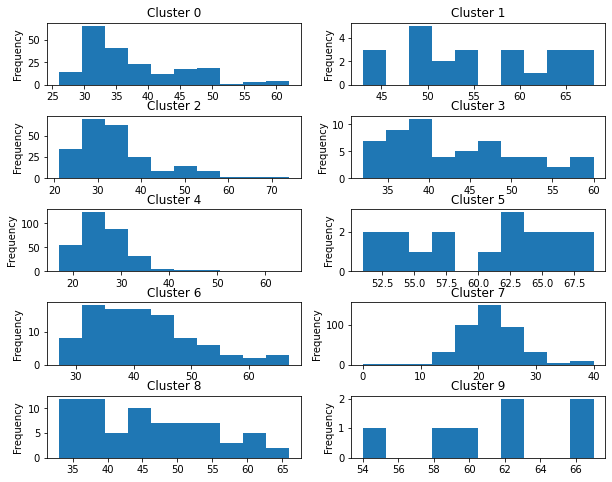

In [188]:
plot_capa(km_df)

In [323]:
_ = df.copy()

#like a left merge but faster
_['cluster'] = _['station_id'].map(dict(zip(km_df.station_id,km_df.cluster)))


_['time'] = pd.to_datetime(df['time'])
_['hour'] = _['time'].dt.hour
_['day'] = _['time'].dt.dayofweek

_.set_index('time', inplace=True)

stacked_df = _.groupby([pd.Grouper('cluster'),
                        pd.Grouper(level='time',freq='H')]).agg({'docks_available':'mean',
                                                                     'mechanical_available':'mean',
                                                                     'ebike_available':'mean',
                                                                     'capacity':max}).reset_index()

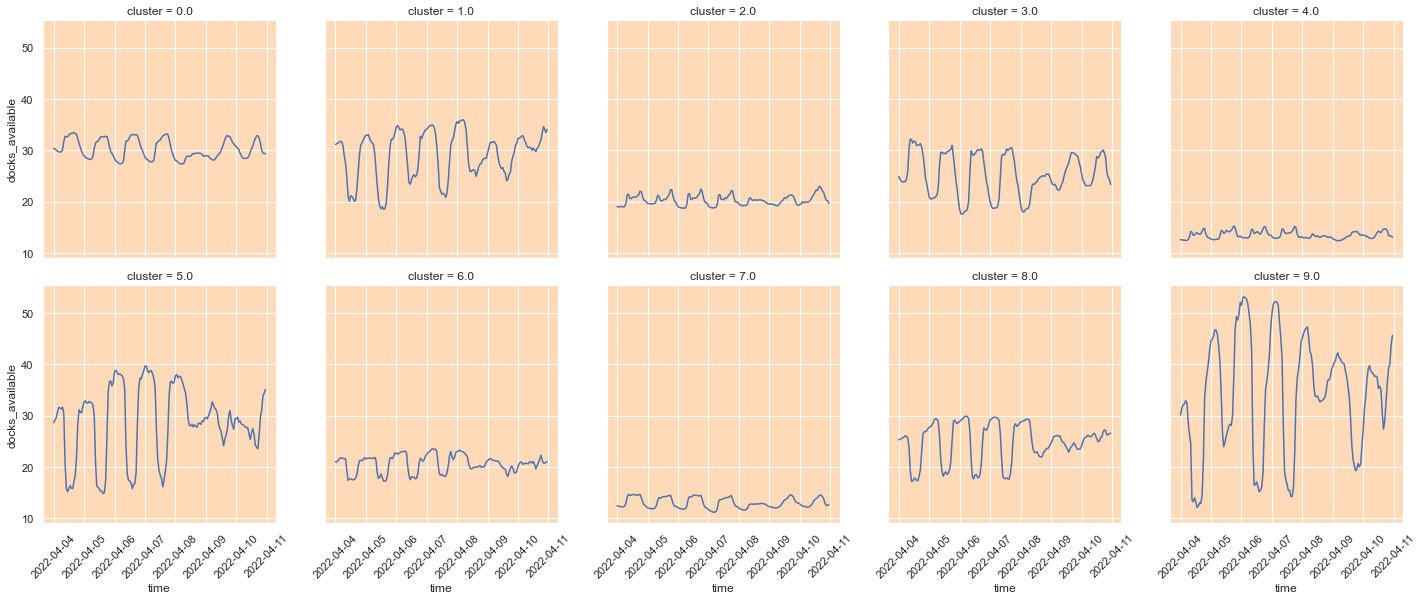

In [344]:
sns.set(rc={'axes.facecolor':'peachpuff'})
#Plot docks available average per cluster on a complete lambda week
g = sns.FacetGrid(data=stacked_df[stacked_df.time.between("2022-04-04 00:00:00","2022-04-10 23:59:59")]
                  , col='cluster', height=4, col_wrap=5)
g.map(sns.lineplot, 'time', 'docks_available')
g.set_xticklabels(rotation=45);

The biggest clusters (7, 4, 2, 0) are __small stations__, they seem to have the __opposite day/night pattern__ in comparison to the other clusters.  
Maybe we can split them geographicaly if our models can't fit this many stations

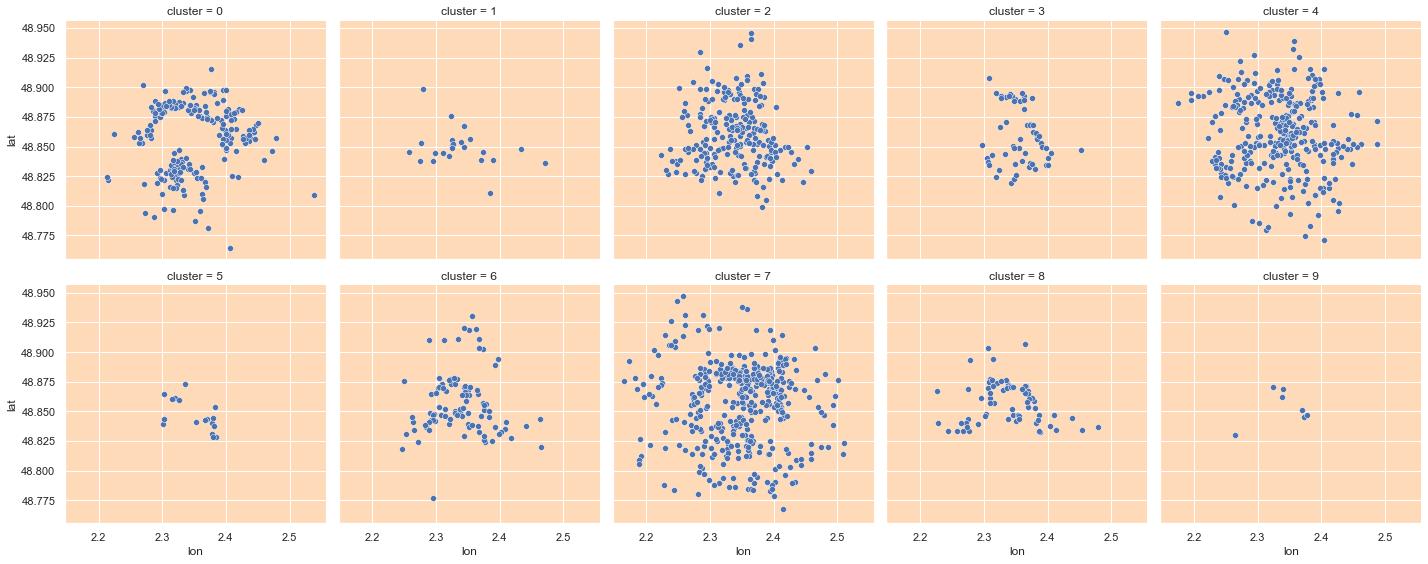

In [343]:
g = sns.FacetGrid(data=km_df, col='cluster', height=4, col_wrap=5)
g.map(sns.scatterplot, 'lon', 'lat')

The biggest custers doesn't seem to be geographicaly designed which makes sense as smaller stations are everywere while the bigger ones (1, 5, 9) are more centrals.  
I'll regroup the small clusters and split the biggests in order to train models for around 80 to 200 stations maximum.

In [345]:
km_df.cluster.value_counts()

7    420
4    311
2    228
0    200
6     97
8     70
3     57
1     23
5     17
9      7
Name: cluster, dtype: int64

In [459]:
regroup_cluster = {9:1, 5:1}

In [469]:
new_st_df = km_df.copy()
new_st_df.cluster = new_st_df.cluster.replace(regroup_cluster)

In [470]:
def split_lat(cluster,lat):
    half_lat = 48.850
    return (cluster + 1) * 11 if lat < half_lat else cluster

def split_lon(cluster,lon):
    half_lon = 2.34
    return (cluster + 1) * 111 if lon < half_lon else cluster

too_big = [cl for cl in new_st_df.cluster.unique() if (new_st_df.cluster==cl).sum()>150]

new_st_df.cluster = new_st_df.apply(lambda df: split_lat(df.cluster,df.lat) if df.cluster in too_big else df.cluster,
                                  axis=1)

too_big = [cl for cl in new_st_df.cluster.unique() if (new_st_df.cluster==cl).sum()>150]

new_st_df.cluster = new_st_df.apply(lambda df: split_lon(df.cluster,df.lon) if df.cluster in too_big else df.cluster,
                                  axis=1)

In [471]:
new_st_df.cluster.value_counts()

7      168
88     148
2      139
0      122
55     114
888    104
4      101
6       97
555     96
33      89
11      78
8       70
3       57
1       47
Name: cluster, dtype: int64

This split will do, let's save our table

In [474]:
new_st_df.set_index('station_id').to_csv(
    '/Users/sebastienvallin/code/Sebastien01/velib_prediction/velib_prediction/data/stations_info.csv')